### Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import KFold, StratifiedKFold 
from catboost import CatBoostClassifier

import re

%matplotlib inline
pd.set_option('display.max_columns', 30)
sns.set_style('darkgrid')

# EDA

In [2]:
data_train = pd.read_csv("train_dataset_train.csv")
data_test = pd.read_csv("test_dataset_test.csv")

In [3]:
print('Train:', data_train.shape)
print('Test:', data_test.shape)

Train: (4839, 17)
Test: (2075, 12)


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RecordNo                              4839 non-null   int64  
 1   Название книги                        4839 non-null   object 
 2   Автор                                 4839 non-null   object 
 3   Ссылка на литрес                      4839 non-null   object 
 4   Рейтинг                               4839 non-null   float64
 5   Количество оценок                     4839 non-null   int64  
 6   Количество отзывов                    4839 non-null   int64  
 7   Имя читателя                          4839 non-null   object 
 8   Оценка книги читателем (из 5 баллов)  4070 non-null   float64
 9   Отзыв                                 4839 non-null   object 
 10  Лайки на отзыв                        4839 non-null   int64  
 11  Дислайки на отзыв

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RecordNo                              2075 non-null   int64  
 1   Название книги                        2075 non-null   object 
 2   Автор                                 2075 non-null   object 
 3   Ссылка на литрес                      2075 non-null   object 
 4   Рейтинг                               2075 non-null   float64
 5   Количество оценок                     2075 non-null   int64  
 6   Количество отзывов                    2075 non-null   int64  
 7   Имя читателя                          2075 non-null   object 
 8   Оценка книги читателем (из 5 баллов)  1757 non-null   float64
 9   Отзыв                                 2075 non-null   object 
 10  Лайки на отзыв                        2075 non-null   int64  
 11  Дислайки на отзыв

Пропуски есть только в столбце: Оценка книги читателем (из 5 баллов). Типы данных сходятся.

In [6]:
data_train.sample(2)

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
695,5593,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Татьяна Селимова,5.0,Прекрасная книга. Отличный слог. Рекомендую. Т...,2,3,0,1,0,0,1
1844,7032,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Илья Смердов,1.0,"Ужасный рассказ(. Неинтересный, сразу видно, ч...",11,12,0,0,0,0,1


In [7]:
data_test.sample(2)

,RecordNo,Название книги,Автор,Ссылка на литрес,Рейтинг,Количество оценок,Количество отзывов,Имя читателя,Оценка книги читателем (из 5 баллов),Отзыв,Лайки на отзыв,Дислайки на отзыв
649,213,Зулейха открывает глаза,Гузель Яхина,https://www.litres.ru/guzel-yahina/zuleyha-otk...,4.6,24719,2103,Вадим Пилютис,1.0,"антикомунистическая пропаганда, прямые намеки ...",0,0
436,6616,Тобол. Много званых,Алексей Иванов,https://www.litres.ru/aleksey-ivanov/tobol-mno...,4.5,1928,110,udots,NaN,"Сразу за обе части. Роман как сочный пирожок, ...",2,0


In [8]:
data_train['RecordNo'].nunique()

4839

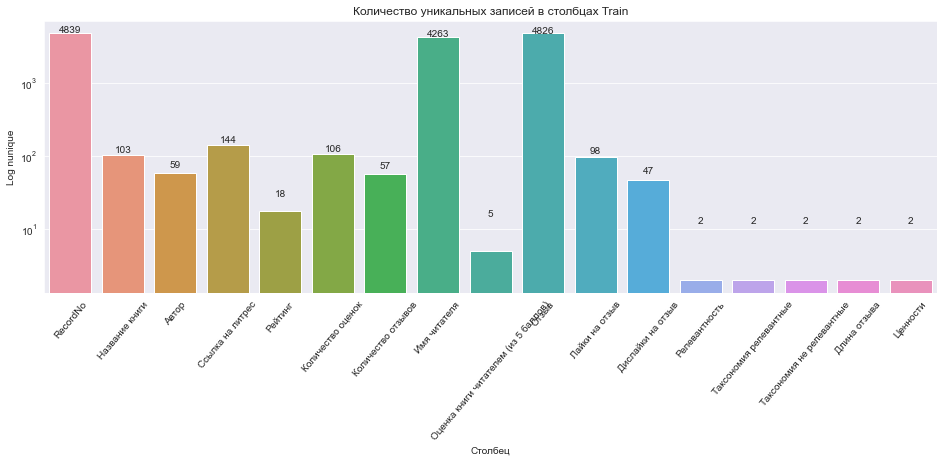

In [9]:
plt.figure(figsize=(16, 5))

cols = data_train.columns
nunique = [data_train[col].nunique() for col in cols] #уникальные записи

ax = sns.barplot(x=cols, y=nunique, log=True)
ax.set(xlabel='Столбец', ylabel='Log nunique', title='Количество уникальных записей в столбцах Train')

# Простовляем кол-во уникальных записей без log.
for p, uniq in zip(ax.patches, nunique):
    ax.text(p.get_x() + p.get_width()/2., uniq + 10, uniq, ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation=50);

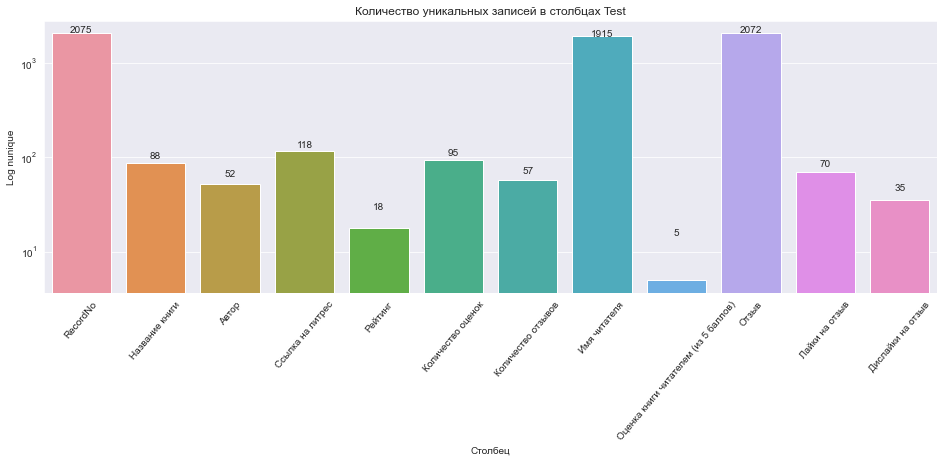

In [10]:
plt.figure(figsize=(16, 5))

cols = data_test.columns
nunique = [data_test[col].nunique() for col in cols] #уникальные записи

ax = sns.barplot(x=cols, y=nunique, log=True)
ax.set(xlabel='Столбец', ylabel='Log nunique', title='Количество уникальных записей в столбцах Test')

# Простовляем кол-во уникальных записей без log.
for p, uniq in zip(ax.patches, nunique):
    ax.text(p.get_x() + p.get_width()/2., uniq + 10, uniq, ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation=50);

### Название книги / Автор / Имя читателя

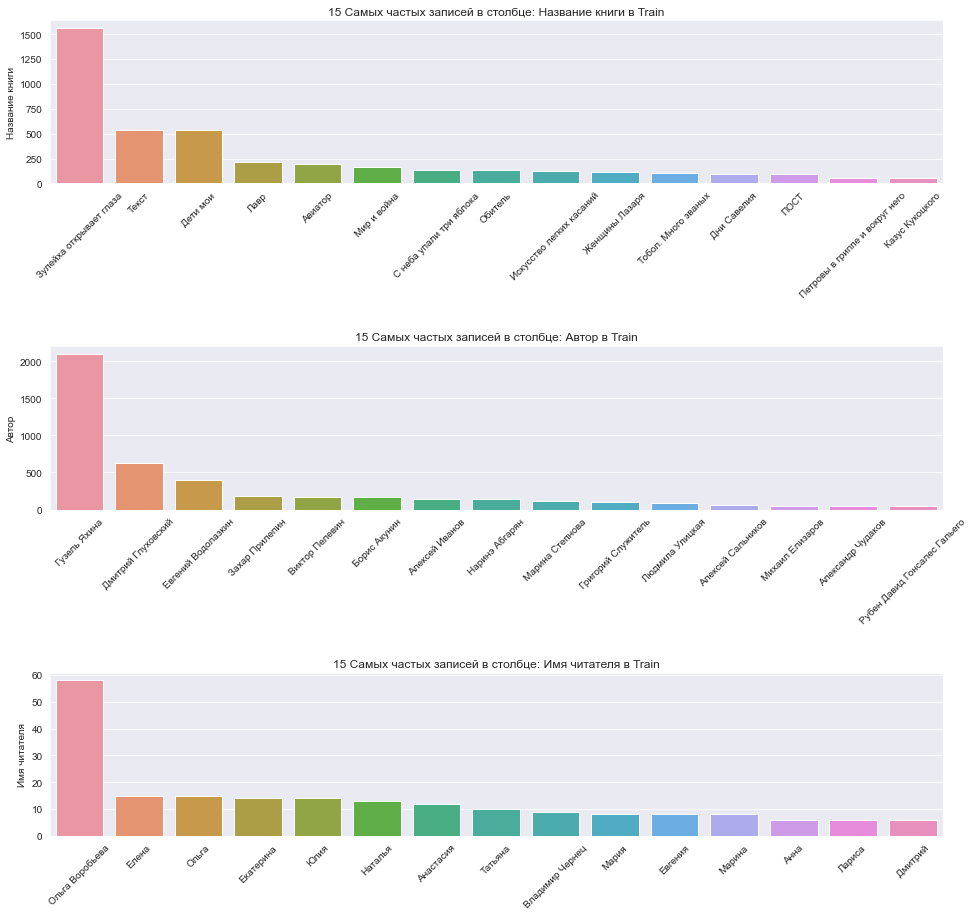

In [11]:
#Train
fig, axs = plt.subplots(nrows=3,figsize=(16,15))
plt.subplots_adjust(hspace=1)

cols = ['Название книги', 'Автор', 'Имя читателя']
for i, col in enumerate(cols):
    values = data_train[col].value_counts().head(15)
    axs[i] = sns.barplot(x=values.index, y=values, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45);
    axs[i].title.set_text(f'15 Самых частых записей в столбце: {col} в Train')
plt.show()


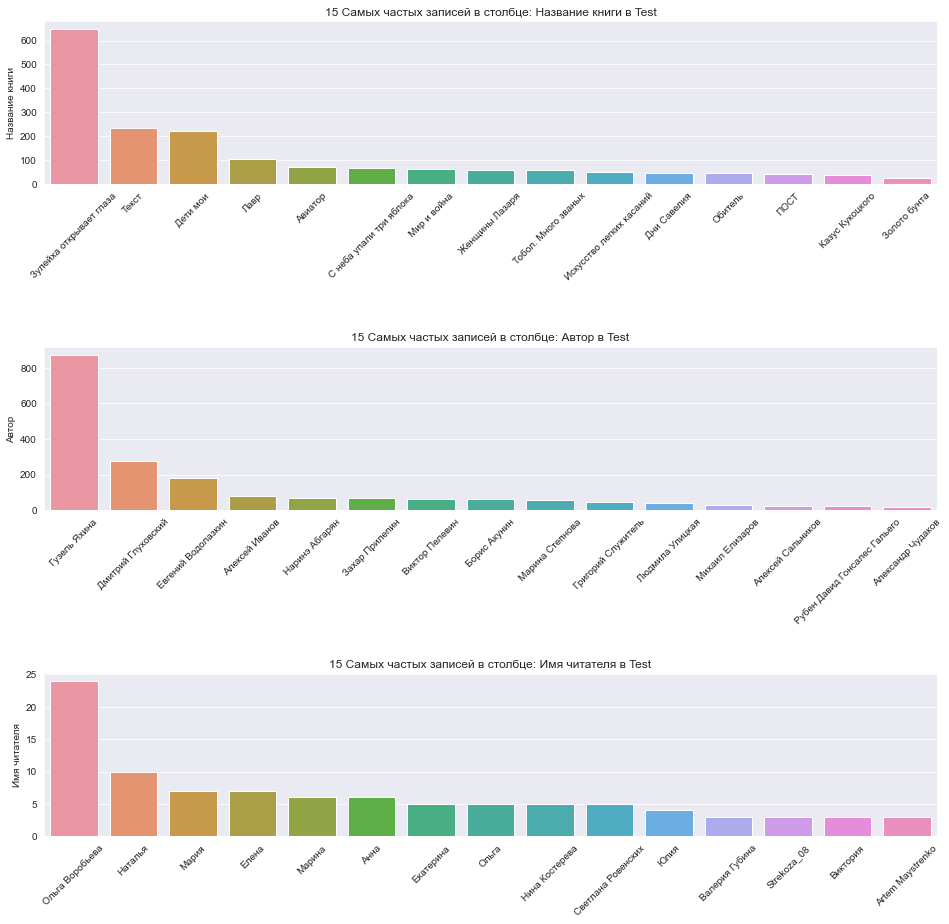

In [12]:
#Test
fig, axs = plt.subplots(nrows=3,figsize=(16,15))
plt.subplots_adjust(hspace=1)

cols = ['Название книги', 'Автор', 'Имя читателя']
for i, col in enumerate(cols):
    values = data_test[col].value_counts().head(15)
    axs[i] = sns.barplot(x=values.index, y=values, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45);
    axs[i].title.set_text(f'15 Самых частых записей в столбце: {col} в Test')
plt.show()


Распределение по названию книги и авторам в Train и Test схоже. Читатели отличаются.

### Numeric cols 

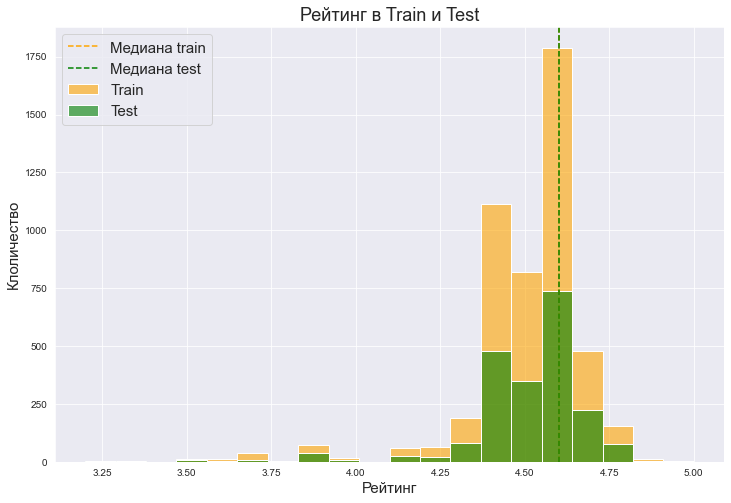

In [13]:
plt.figure(figsize=(12,8))
feature = 'Рейтинг'

data_0 = data_train[feature]
data_1 = data_test[feature]

g_0 = sns.histplot(x=data_0,color='orange',alpha=0.6, bins = 20)
g_1 = sns.histplot(x=data_1,color='green',alpha=0.6, bins = 20)

g_0.axvline(data_0.median(),linestyle = '--',color='orange')
g_1.axvline(data_1.median(),linestyle = '--',color='green')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'{feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

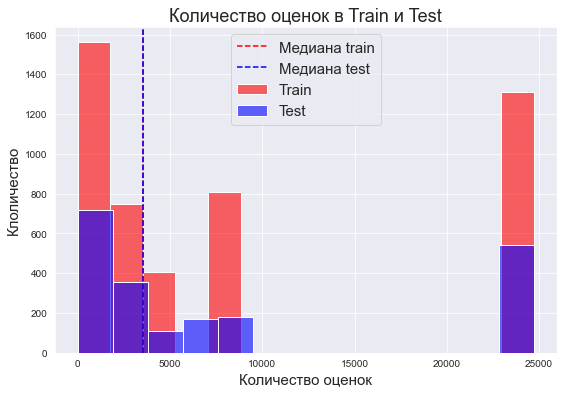

In [14]:
plt.figure(figsize=(9,6))
feature = 'Количество оценок'

data_0 = data_train[feature]
data_1 = data_test[feature]

g_0 = sns.histplot(x=data_0,color='red',alpha=0.6)
g_1 = sns.histplot(x=data_1,color='blue',alpha=0.6)

g_0.axvline(data_0.median(),linestyle = '--',color='red')
g_1.axvline(data_1.median(),linestyle = '--',color='blue')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'{feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

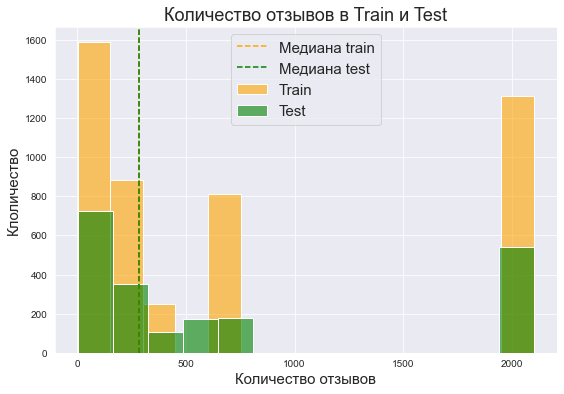

In [15]:
plt.figure(figsize=(9,6))
feature = 'Количество отзывов'

data_0 = data_train[feature]
data_1 = data_test[feature]

g_0 = sns.histplot(x=data_0,color='orange',alpha=0.6)
g_1 = sns.histplot(x=data_1,color='green',alpha=0.6)

g_0.axvline(data_0.median(),linestyle = '--',color='orange')
g_1.axvline(data_1.median(),linestyle = '--',color='green')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'{feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

Распределение "Количество отзывов" такое же как у "Количество оценок". Возможно столбцы повторяют друг друга или абсолютно скоррелированы.  

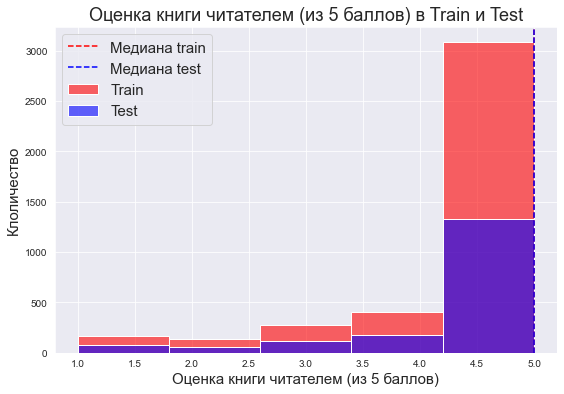

In [16]:
plt.figure(figsize=(9,6))
feature = 'Оценка книги читателем (из 5 баллов)'

data_0 = data_train[feature]
data_1 = data_test[feature]

g_0 = sns.histplot(x=data_0, color='red', alpha=0.6, bins=5)
g_1 = sns.histplot(x=data_1, color='blue', alpha=0.6, bins=5)

g_0.axvline(data_0.median(),linestyle = '--',color='red')
g_1.axvline(data_1.median(),linestyle = '--',color='blue')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'{feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

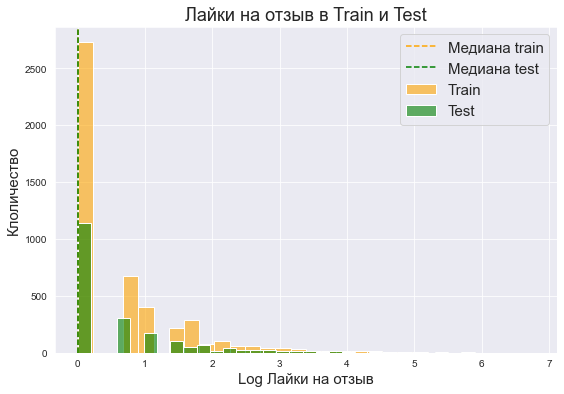

In [17]:
plt.figure(figsize=(9,6))
feature = 'Лайки на отзыв'

data_0 = np.log1p(data_train[feature])
data_1 = np.log1p(data_test[feature])

g_0 = sns.histplot(x=data_0,color='orange',alpha=0.6, bins = 30)
g_1 = sns.histplot(x=data_1,color='green',alpha=0.6, bins = 30)

g_0.axvline(data_0.median(),linestyle = '--',color='orange')
g_1.axvline(data_1.median(),linestyle = '--',color='green')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'Log {feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

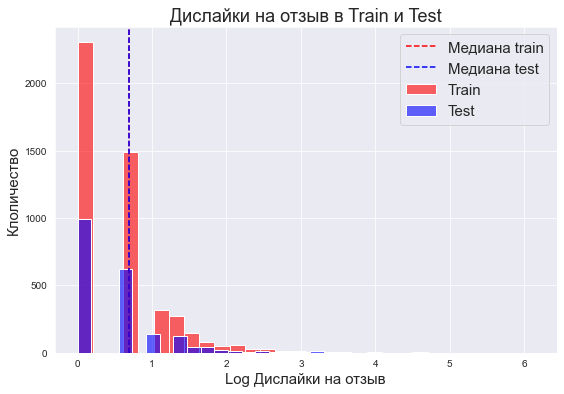

In [18]:
plt.figure(figsize=(9,6))
feature = 'Дислайки на отзыв'

data_0 = np.log1p(data_train[feature])
data_1 = np.log1p(data_test[feature])

g_0 = sns.histplot(x=data_0, color='red', alpha=0.6, bins = 30)
g_1 = sns.histplot(x=data_1, color='blue', alpha=0.6, bins = 30)

g_0.axvline(data_0.median(),linestyle = '--',color='red')
g_1.axvline(data_1.median(),linestyle = '--',color='blue')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'Log {feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

### Preprocess text

In [19]:
def top_n_count(series,n=30):
    """Функция считает n самых популярных слов серии.
    Args: 
        series: Серия из строк.
    Returns:
        DataFrame.
    """
    data_list = series.str.split().tolist()
    counter = Counter()
    for word in data_list:
        counter.update(word)
    df = pd.DataFrame(counter.most_common(n),columns=['word','count'])    
    return df

def preprocess_text(text: str) -> str:
    """Функция для чистки текста."""
    
    if not isinstance(text, str):
        msg = "Text must be a string"
        # logger.warning(msg)
        raise TypeError(msg)

    text = text.lower()
    text = re.sub(r"[^а-яА-Яa-zA-Z0-9ё\-\\@/+=_%№ ]", " ", text)
    text = re.sub(r"ё", "е", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

def stemming_text(text):
    stemmer = SnowballStemmer('russian')
    stemmed_text = [stemmer.stem(i) for i in word_tokenize(text)]
    result = ' '.join(stemmed_text)
    return result

stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru: #убираем стоп слова
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        tokens = ' '.join(tokens)
        return tokens
    return doc

def barplot_top_n (df,x, y,title,fig_size=(15,5)):
    plt.figure(figsize=fig_size)
    sns.barplot(data = df, x=x, y=y)
    plt.title(f'Top {df.shape[0]} common words in '+title ,fontsize = 15)
    plt.xticks(rotation = 90,fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x,size=18)
    plt.ylabel(y,size=18)
    plt.show() 

In [20]:
process_feedback_train = data_train['Отзыв'].apply(lambda row: preprocess_text(row))
process_feedback_train = process_feedback_train.apply(lambda row: lemmatize(row))

process_feedback_test = data_test['Отзыв'].apply(lambda row: preprocess_text(row))
process_feedback_test = process_feedback_test.apply(lambda row: lemmatize(row))


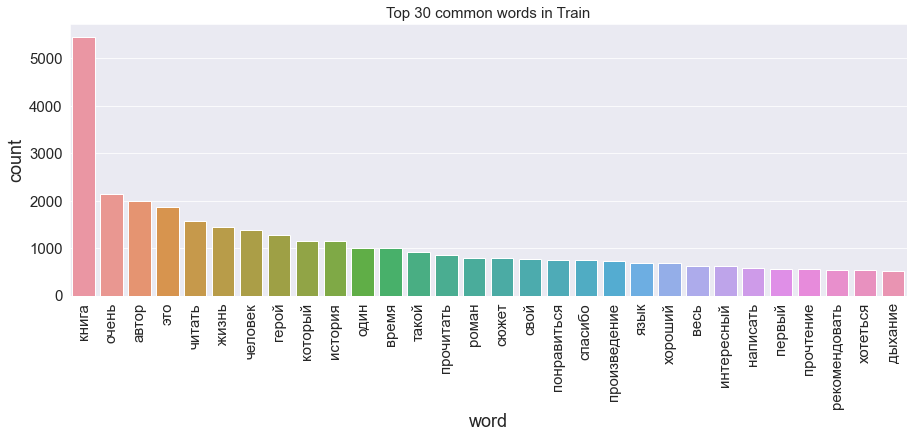

In [21]:
barplot_top_n (df=top_n_count(process_feedback_train),x='word', y='count',title ='Train',fig_size=(15,5))

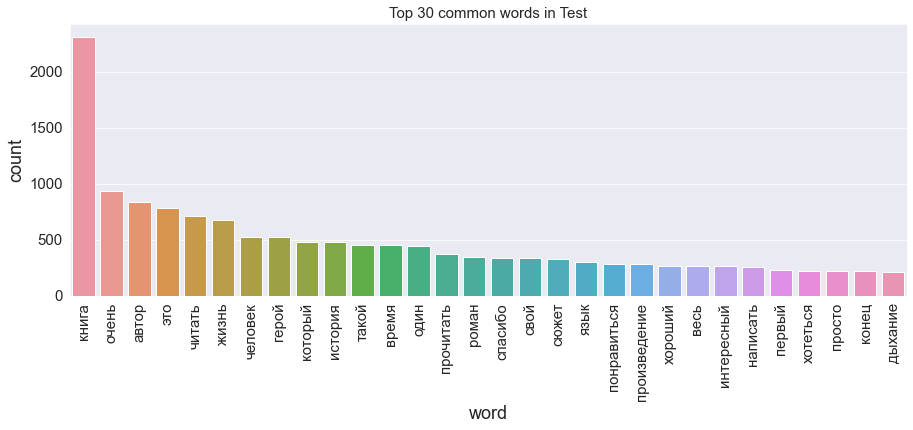

In [22]:
barplot_top_n (df=top_n_count(process_feedback_test),x='word', y='count',title ='Test',fig_size=(15,5))

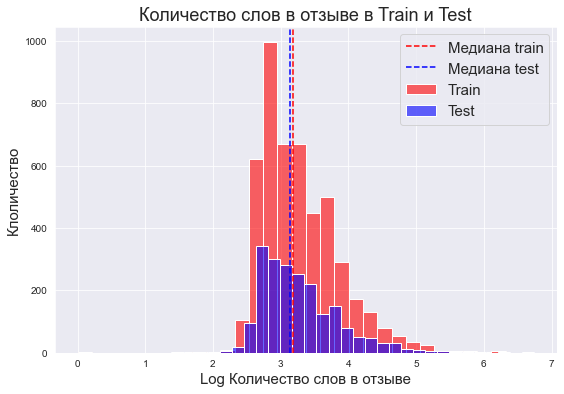

In [23]:
plt.figure(figsize=(9,6))
feature = 'Количество слов в отзыве'

data_0 = np.log(process_feedback_train.apply(lambda row: len(row.split())))
data_1 = np.log(process_feedback_test.apply(lambda row: len(row.split())))

g_0 = sns.histplot(x=data_0, color='red', alpha=0.6, bins = 30)
g_1 = sns.histplot(x=data_1, color='blue', alpha=0.6, bins = 30)

g_0.axvline(data_0.median(),linestyle = '--',color='red')
g_1.axvline(data_1.median(),linestyle = '--',color='blue')

plt.ticklabel_format(style='plain', axis='x')
plt.title(f'{feature} в Train и Test',size=18)
plt.xlabel(f'Log {feature}',size=15)
plt.ylabel('Клоличество',size=15)
plt.legend(['Медиана train','Медиана test','Train','Test'],fontsize=15)
plt.show()

### Target

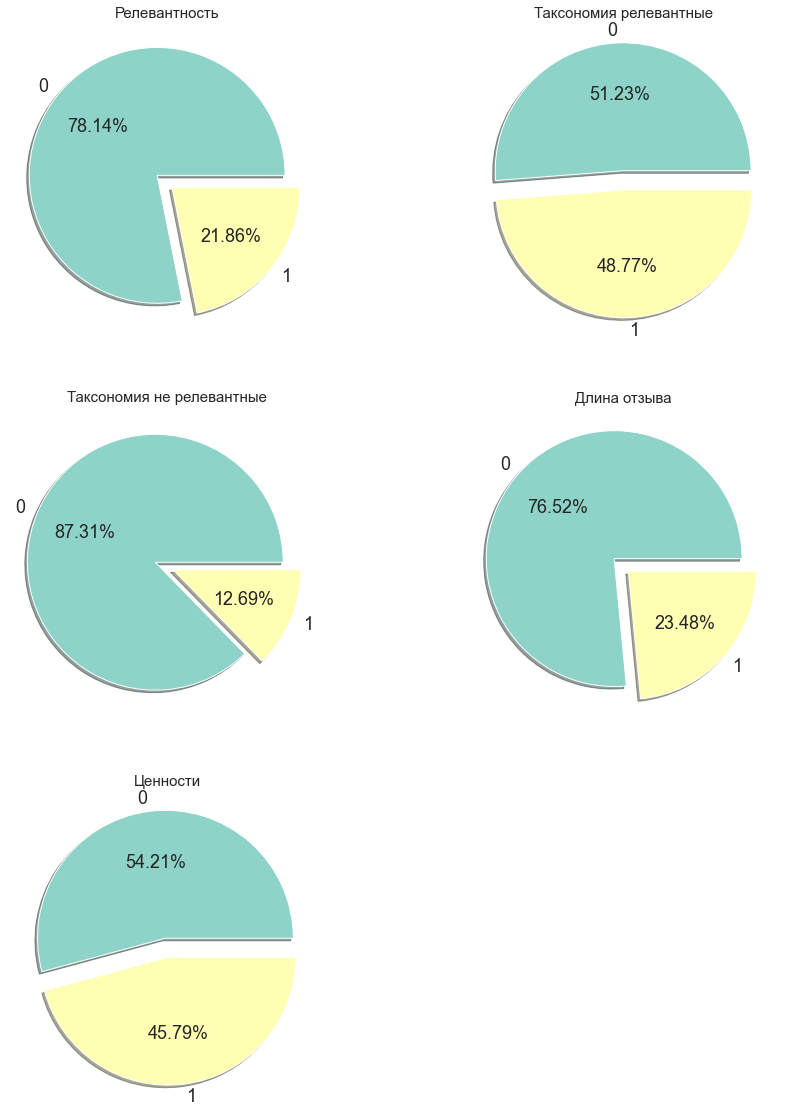

In [24]:
fig, axs = plt.subplots(ncols=2,nrows=3,figsize=(15,20))
fig.delaxes(axs[2,1])
counts = data_train['Релевантность'].value_counts()
mylabels = ["0", "1"]
text_font = {"fontsize":18}
explode = [0.1,0.05]

axs[0][0].pie(data_train['Релевантность'].value_counts(), labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
axs[0][0].set_title('Релевантность', fontsize=15)
axs[0][1].pie(data_train['Таксономия релевантные'].value_counts(), labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
axs[0][1].set_title('Таксономия релевантные', fontsize=15)
axs[1][0].pie(data_train['Таксономия не релевантные'].value_counts(), labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
axs[1][0].set_title('Таксономия не релевантные', fontsize=15)
axs[1][1].pie(data_train['Длина отзыва'].value_counts(), labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
axs[1][1].set_title('Длина отзыва', fontsize=15)
axs[2][0].pie(data_train['Ценности'].value_counts(), labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
axs[2][0].set_title('Ценности', fontsize=15)
plt.show()


### Correlation

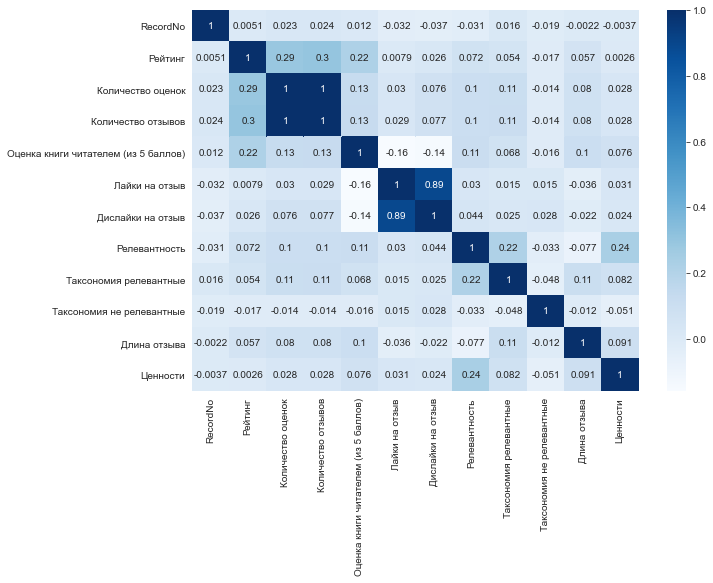

In [25]:
data_train_corr = data_train.corr()
plt.figure(figsize=(10,7))
sns.heatmap(data_train_corr, cmap="Blues", annot=True)
plt.show()

Корреляция 'Количество оценок' и 'Количество отзывов' => 1.  
Корреляция 'Лайки на отзыв' и 'Дислайки на отзыв' => 0.89

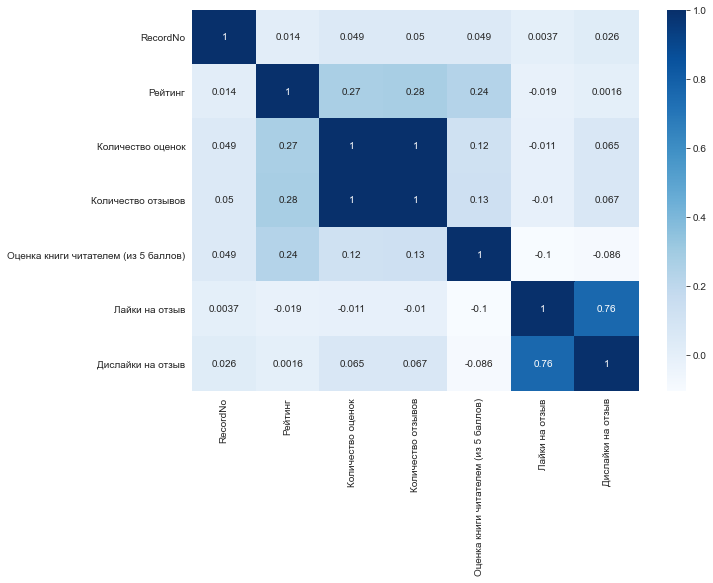

In [26]:
data_test_corr = data_test.corr()
plt.figure(figsize=(10,7))
sns.heatmap(data_test_corr, cmap="Blues", annot=True)
plt.show()

### TF-IDF

In [27]:
tf = TfidfVectorizer()
tf.fit(process_feedback_train)
X_train = tf.transform(process_feedback_train)
X_test = tf.transform(process_feedback_test)

In [28]:
print(X_train.shape)
print(X_test.shape)

(4839, 15291)
(2075, 15291)


In [29]:
X_train = pd.DataFrame(data=X_train.todense(), columns=tf.get_feature_names())
X_test = pd.DataFrame(data=X_test.todense(), columns=tf.get_feature_names())

In [30]:
to_drop = ['RecordNo', 'Ссылка на литрес', 'Отзыв']
train =data_train.drop(to_drop, axis=1).merge(X_train, how='inner', left_index=True, right_index=True)
test = data_test.drop(to_drop, axis=1).merge(X_test, how='inner', left_index=True, right_index=True)

In [31]:
# кол-во слов и символов в отзыве.
train['word_len'] = process_feedback_train.apply(lambda x: len(x.split()))
train['char_len'] = process_feedback_train.apply(lambda x: len(x.replace(' ', '')))

test['word_len'] = process_feedback_test.apply(lambda x: len(x.split()))
test['char_len'] = process_feedback_test.apply(lambda x: len(x.replace(' ', '')))

In [32]:
cat_cols = ['Название книги', 'Автор', 'Имя читателя']
traget_cols =  ['Релевантность', 'Таксономия релевантные', 'Таксономия не релевантные', 'Длина отзыва', 'Ценности']

### Model

In [33]:
n_splits = 5
N = len(traget_cols)*n_splits
clfs = []

# Для каждого таргета обучаем CatBoost на 5 фолдах
for col in traget_cols:
    print(col)
    X = train.drop(traget_cols, axis=1)
    y = train[col].values

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = CatBoostClassifier(iterations = 10000,
                              loss_function = 'Logloss', eval_metric = 'Recall',
                              cat_features = cat_cols, random_seed=42, 
                              task_type='CPU', auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=500)
        clfs.append(clf)

        clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                verbose = 500, use_best_model = True, plot = False)
        
assert len(clfs) == N # Всего 25 моделей (5 таргетов * 5 фолдов)

Релевантность
Learning rate set to 0.016259
0:	learn: 0.3600945	test: 0.3744076	best: 0.3744076 (0)	total: 801ms	remaining: 2h 13m 33s
500:	learn: 0.5879575	test: 0.4976303	best: 0.5071090 (390)	total: 1m 43s	remaining: 32m 43s
1000:	learn: 0.7438017	test: 0.5545024	best: 0.5592417 (965)	total: 3m 11s	remaining: 28m 41s
1500:	learn: 0.8831169	test: 0.5355450	best: 0.5639810 (1046)	total: 4m 39s	remaining: 26m 21s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5639810427
bestIteration = 1046

Shrink model to first 1047 iterations.
Learning rate set to 0.016259
0:	learn: 0.3581560	test: 0.3537736	best: 0.3537736 (0)	total: 183ms	remaining: 30m 33s
500:	learn: 0.5910165	test: 0.4575472	best: 0.4669811 (386)	total: 1m 37s	remaining: 30m 48s
1000:	learn: 0.7399527	test: 0.4905660	best: 0.4952830 (966)	total: 3m 3s	remaining: 27m 30s
1500:	learn: 0.8687943	test: 0.5094340	best: 0.5094340 (1463)	total: 4m 28s	remaining: 25m 19s
2000:	learn: 0.9444444	test: 0.5141509	best

Learning rate set to 0.01626
0:	learn: 0.0121012	test: 0.0044053	best: 0.0044053 (0)	total: 182ms	remaining: 30m 23s
500:	learn: 0.6666667	test: 0.5198238	best: 0.5242291 (322)	total: 1m 30s	remaining: 28m 30s
1000:	learn: 0.8371837	test: 0.5286344	best: 0.5418502 (857)	total: 2m 51s	remaining: 25m 37s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5418502203
bestIteration = 857

Shrink model to first 858 iterations.
Ценности
Learning rate set to 0.016259
0:	learn: 0.6503097	test: 0.6469466	best: 0.6469466 (0)	total: 168ms	remaining: 28m 1s
500:	learn: 0.9523583	test: 0.9236641	best: 0.9236641 (498)	total: 1m 18s	remaining: 24m 49s
1000:	learn: 0.9747499	test: 0.9427481	best: 0.9446565 (628)	total: 2m 37s	remaining: 23m 39s
1500:	learn: 0.9833254	test: 0.9484733	best: 0.9484733 (1250)	total: 3m 57s	remaining: 22m 22s
2000:	learn: 1.0000000	test: 0.9561069	best: 0.9561069 (1945)	total: 5m 18s	remaining: 21m 11s
Stopped by overfitting detector  (500 iterations wait)

In [34]:
# Берём predict_proba и скоры из кросс-валидации
y_pred = []
scores = []
for clf in clfs:
    y_pred.append(list(clf.predict_proba(test)[:,1]))
    scores.append(clf.best_score_['validation']['Recall'])

In [35]:
# Усредняем predict_proba для каждог таргета
final_preds = []
mean_score = []
for i in range(5,26,5):
    pred_list = y_pred[i-5:i]
    final_preds.append(np.array(y_pred[i-5:i]).sum(axis=0) / 5)
    mean_score.append(np.array(scores[i-5:i]).sum(axis=0) / 5)
    

In [36]:
# Recall на кросс-валидации
for score,name in zip(mean_score, traget_cols):
    print(name, ':', score)
print('mean:',sum(mean_score)/len(mean_score))

Релевантность : 0.49251095412679957
Таксономия релевантные : 0.9862846203975236
Таксономия не релевантные : 0.9544049047047848
Длина отзыва : 0.5915565345080764
Ценности : 0.9595936023264267
mean: 0.7968701232127222


### Thresholds

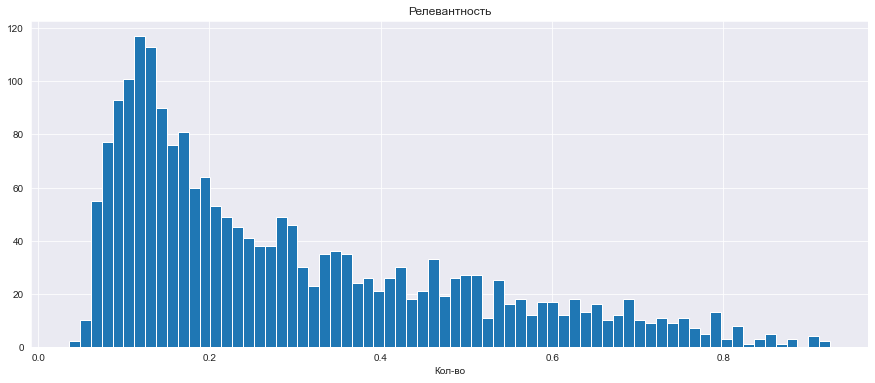

In [57]:
plt.figure(figsize=(15,6))
pd.Series(final_preds[0]).hist(bins=70)
plt.title('Релевантность')
plt.xlabel('Порог')
plt.xlabel('Кол-во')
plt.show()

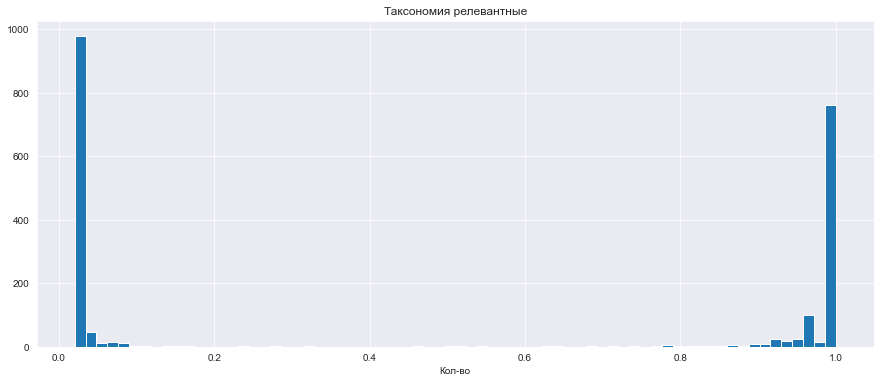

In [58]:
plt.figure(figsize=(15,6))
pd.Series(final_preds[1]).hist(bins=70)
plt.title('Таксономия релевантные')
plt.xlabel('Порог')
plt.xlabel('Кол-во')
plt.show()

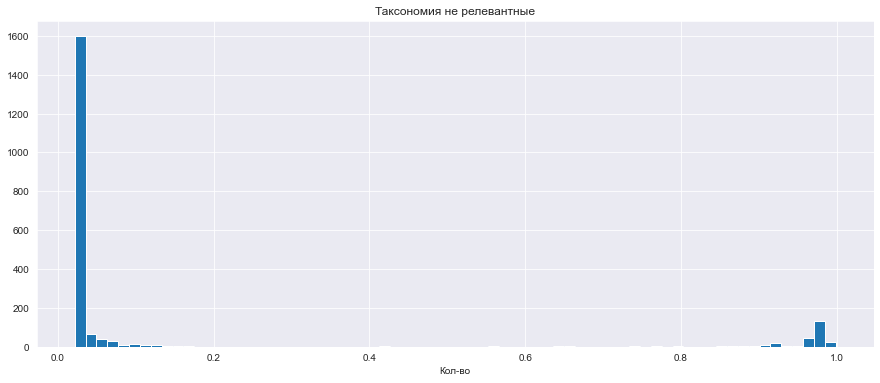

In [59]:
plt.figure(figsize=(15,6))
pd.Series(final_preds[2]).hist(bins=70)
plt.title('Таксономия не релевантные')
plt.xlabel('Порог')
plt.xlabel('Кол-во')
plt.show()

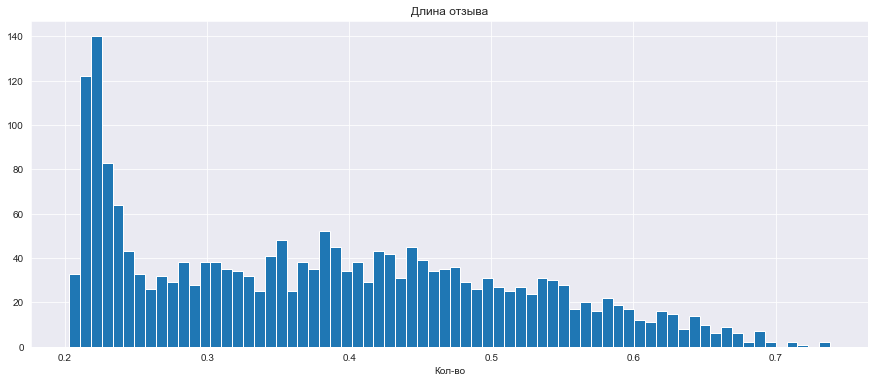

In [60]:
plt.figure(figsize=(15,6))
pd.Series(final_preds[3]).hist(bins=70)
plt.title('Длина отзыва')
plt.xlabel('Порог')
plt.xlabel('Кол-во')
plt.show()

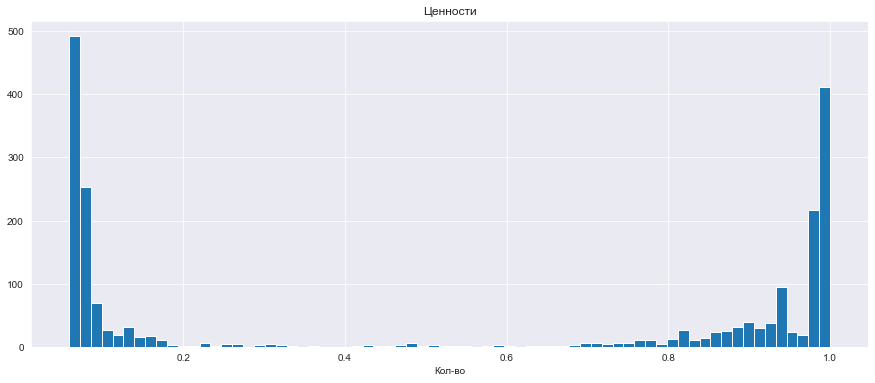

In [61]:
plt.figure(figsize=(15,6))
pd.Series(final_preds[4]).hist(bins=70)
plt.title('Ценности')
plt.xlabel('Порог')
plt.xlabel('Кол-во')
plt.show()

In [42]:
predictions = []
for pred in final_preds:
    predictions.append(np.where(pred <=0.5, 0 ,1))
target_1 = np.where(final_preds[0]  <= 0.3, 0 ,1) # Для признака Релевантность понизим thresh до 0.3
predictions[0] = target_1

### Submition 

In [43]:
subm = pd.DataFrame(np.array(predictions).T, columns=traget_cols)
subm['RecordNo']= data_test['RecordNo']
subm = subm[['RecordNo', 'Релевантность', 'Таксономия релевантные',
       'Таксономия не релевантные', 'Длина отзыва', 'Ценности']]
subm.to_csv('submition_result.csv', index=False)

In [44]:
subm

,RecordNo,Релевантность,Таксономия релевантные,Таксономия не релевантные,Длина отзыва,Ценности
0,3366,1,0,0,1,1
1,3952,0,1,0,0,0
2,6852,1,0,0,0,1
3,4586,0,0,0,0,1
4,4677,1,1,0,0,0
...,...,...,...,...,...,...
2070,4661,0,1,1,1,1
2071,1547,0,0,1,0,0
2072,6071,1,1,0,0,1
2073,3805,1,1,0,1,1


### Feature importance

In [45]:
def plot_importance(df, best_model, height, title,top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    plt.title(title)
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

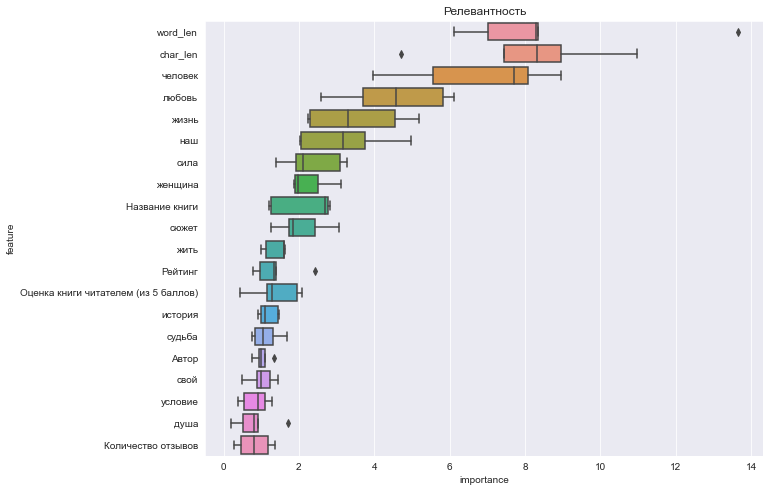

In [46]:
df_feats_imp = plot_importance(df= test, best_model = clfs[0:5],height= 0.40, title ='Релевантность', top_n=20)

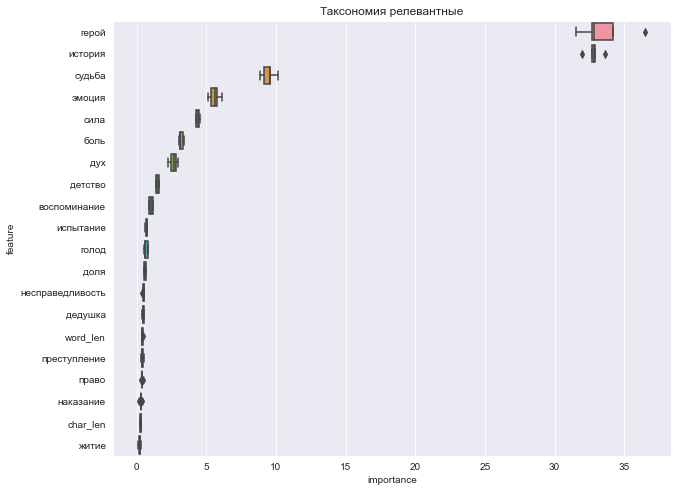

In [47]:
df_feats_imp = plot_importance(df= test, best_model = clfs[5:10],height= 0.40, title ='Таксономия релевантные', top_n=20)

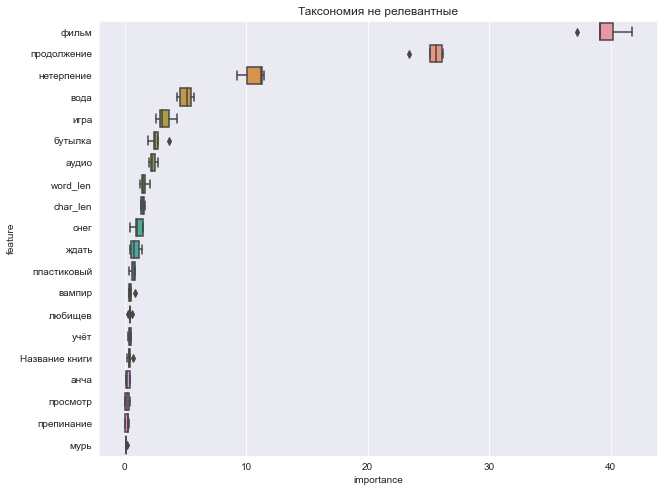

In [49]:
df_feats_imp = plot_importance(df= test, best_model = clfs[10:15],height= 0.40, title='Таксономия не релевантные', top_n=20)

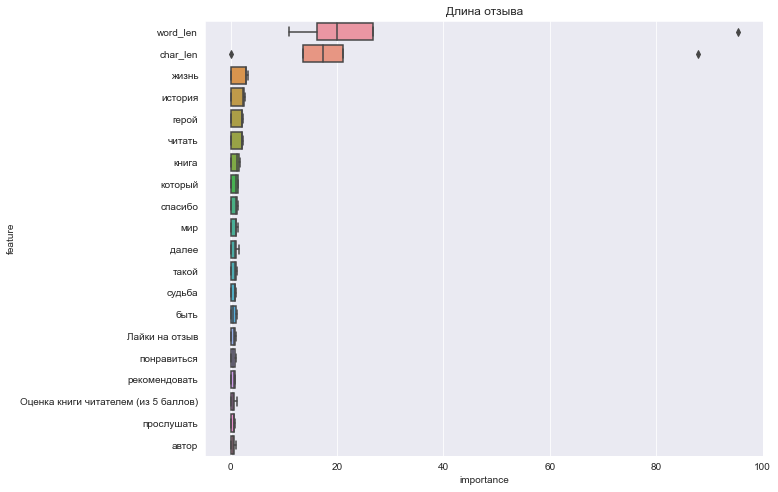

In [50]:
df_feats_imp = plot_importance(df= test, best_model = clfs[15:20],height= 0.40, title ='Длина отзыва', top_n=20)

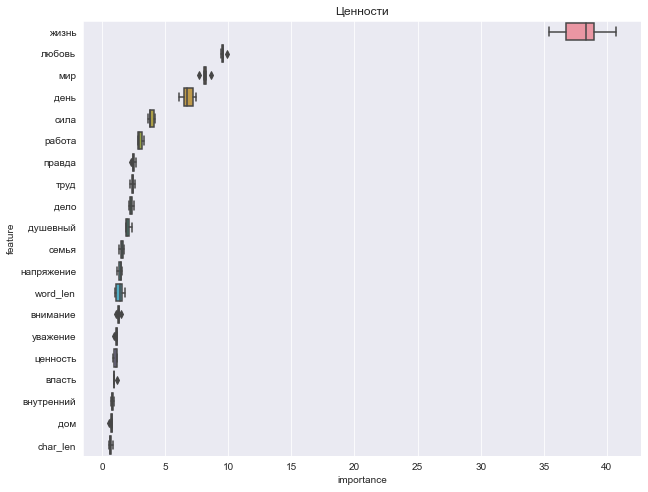

In [51]:
df_feats_imp = plot_importance(df= test, best_model = clfs[20:25],height= 0.40, title ='Ценности', top_n=20)